In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import copy

# Creates new graph
G = nx.Graph()

# Adding the cities
G.add_nodes_from(['Amsterdam', 'Berlin', 'Cologne', 'London', 'Brussels', 'Frankfurt',
                  'Paris', 'Lyon', 'Milan', 'Rome', 'Barcelona', 'Madrid'])


# Adding the weighted edges
G.add_edge("Amsterdam", "Berlin", time=364, cost=235)
G.add_edge("Amsterdam", "Cologne", time=120, cost=40)
G.add_edge("Amsterdam", "Brussels", time=105, cost=48)

G.add_edge("Berlin", "Amsterdam", time=364, cost=235)
G.add_edge("Berlin", "Frankfurt", time=232, cost=125)

G.add_edge("Cologne", "Amsterdam", time=120, cost=40)
G.add_edge("Cologne", "Frankfurt", time=120, cost=40)

G.add_edge("Frankfurt", "Berlin", time=232, cost=125)
G.add_edge("Frankfurt", "Cologne", time=120, cost=40)
G.add_edge("Frankfurt", "Paris", time=480, cost=345)
G.add_edge("Frankfurt", "Milan", time=454, cost=240)

G.add_edge("Brussels", "Amsterdam", time=105, cost=48)
G.add_edge("Brussels", "Paris", time=82, cost=80)

G.add_edge("London", "Paris", time=136, cost=98)
G.add_edge("London", "Brussels", time=136, cost=98)

G.add_edge("Paris", "London", time=136, cost=98)
G.add_edge("Paris", "Brussels", time=82, cost=80)
G.add_edge("Paris", "Frankfurt", time=480, cost=345)
G.add_edge("Paris", "Lyon", time=112, cost=185)
G.add_edge("Paris", "Barcelona", time=390, cost=400)
G.add_edge("Paris", "Madrid", time=225, cost=380)

G.add_edge("Lyon", "Paris", time=112, cost=185)
G.add_edge("Lyon", "Milan", time=176, cost=180)
G.add_edge("Lyon", "Barcelona", time=200, cost=320)

G.add_edge("Milan", "Frankfurt", time=454, cost=240)
G.add_edge("Milan", "Rome", time=168, cost=125)
G.add_edge("Milan", "Lyon", time=176, cost=180)

G.add_edge("Barcelona", "Paris", time=390, cost=400)
G.add_edge("Barcelona", "Lyon", time=200, cost=320)
G.add_edge("Barcelona", "Madrid", time=150, cost=98)

G.add_edge("Madrid", "Paris", time=225, cost=380)
G.add_edge("Madrid", "Barcelona", time=150, cost=98)


In [2]:
# We create a positions dictionary to place every node in a determined position
pos = {
        "London": (0.5, 6),
        "Madrid": (0, 0),
        "Paris": (1.5, 4),
        "Barcelona": (1, 1),
        "Brussels": (2, 5),
        "Amsterdam": (2.5, 7),
        "Lyon": (2.5, 2.5),
        "Cologne": (3, 6),
        "Frankfurt": (3.5, 5),
        "Milan": (3.5, 2.5),
        "Berlin": (4, 7),
        "Rome": (4, 1.5),
      }

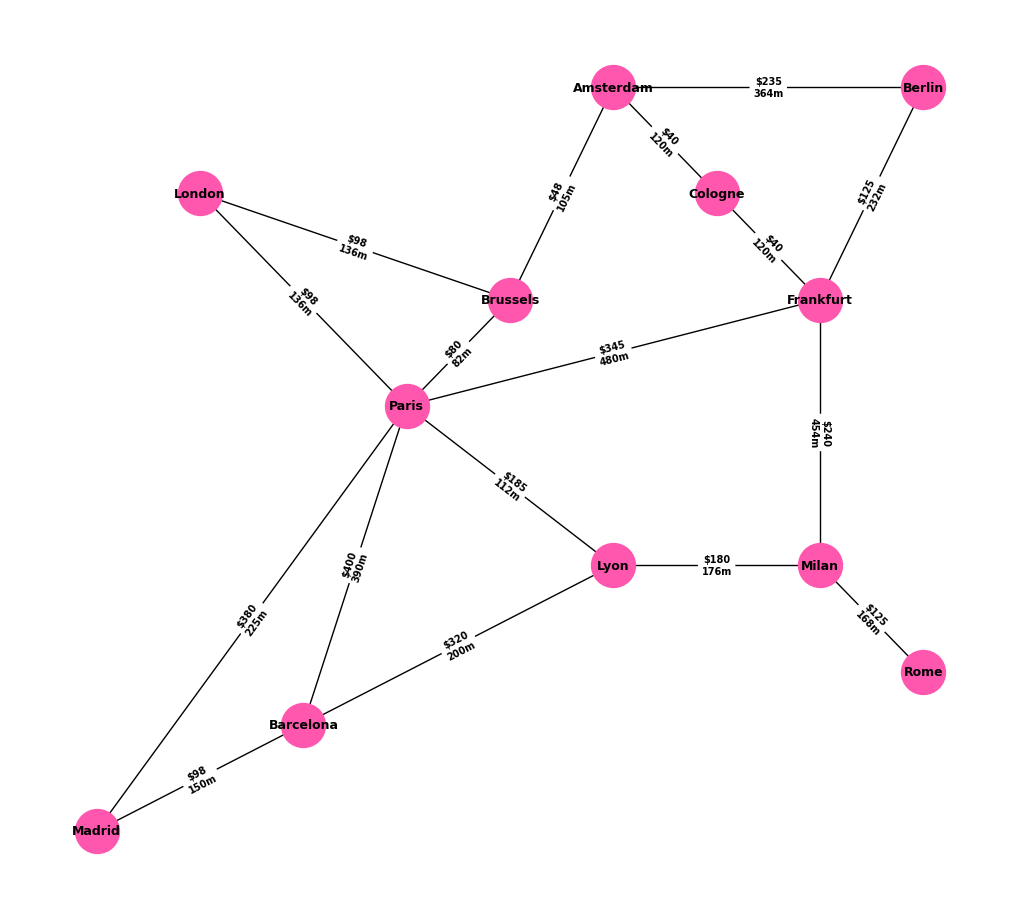

In [3]:
edge_labels = {}
# this assumes all the edges have the same labels 'cost' and 'time' 
for u, v, data in G.edges(data=True):
    edge_labels[u, v] = f"${data['cost']}\n{data['time']}m"

plt.figure(figsize=(10, 9))

# Drawing the graph
nx.draw(G, pos, with_labels=True, node_color='#FF56AE', font_weight='bold', font_size=9, node_size=1000)

# We add the weigths to every edge
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_weight='bold')

# Show the graph on screen
plt.show()

In [4]:
def generate_random_path():
    # Start at a random node
    current_node = random.choice(list(G.nodes()))

    # Initialize the path, time and cost
    path = [current_node]
    time = 0
    cost = 0

    # Traverse the graph until the time constraint is met or no more neighbors are available
    unique = 0
    while time < 4320:
      # Get the neighbors of the current node
      neighbors = list(G[current_node])

      # Remove any neighbors that have already been visited
      unvisited_neighbors = [n for n in neighbors if n not in path]
      if not unvisited_neighbors:
          break

      # Choose a random unvisited neighbor
      next_node = random.choice(unvisited_neighbors)

      # Update the path, time and cost
      path.append(next_node)
      edge = G[current_node][next_node]
      time += edge['time']
      cost += edge['cost']
      
      # Move to the next node
      current_node = next_node
    return path, time, cost

In [5]:
def path_fitness(path):

    for i in range(len(path)-1):
      try:
        edge = G[path[i]][path[i+1]]
      except:
        return 0

    # Calculate the sum of the cost of the path
    cost = 1/sum(G[path[i]][path[i+1]]['cost'] for i in range(len(path)-1))
    
    # Calculate the number of unique nodes in the path
    unique_nodes = len(set(path))

    # Return the sum of the cost and the number of unique nodes
    return cost + unique_nodes

In [6]:
# Create an individual path
def create_individual():
    path, time, cost = generate_random_path()
    fitness = path_fitness(path)
    path_dict = {'path': path, 'time': time, 'cost': cost, 'fitness': fitness}
    
    return path_dict

In [7]:
# Create the first generation of paths
def firstGeneration(genSize):
  population = []
  for i in range(genSize):
      path = create_individual()
      population.append(path)
  return population

In [8]:
# Find the two best paths with the highest fitness scores
def sorting_gen(paths):
    # Sort the paths based on their fitness scores
    sorted_paths = sorted(paths, key=lambda x: x['fitness'], reverse = True)

    # Return the list of best paths
    return sorted_paths

In [9]:
def calculate_time_and_cost(path):
    total_time = 0
    total_cost = 0
    for i in range(len(path)-1):

      try:
        edge = G[path[i]][path[i+1]]
      except:
        return 0, 0

      total_time += edge['time']
      total_cost += edge['cost']
    return total_time, total_cost

In [10]:
def single_point_crossover(path_1, path_2):
    
    # Choose a random crossover point
    crossover_point = random.randint(1, len(path_1) - 1)
    
    # Create the new paths by swapping the tails of the paths
    new_path_1 = path_1['path'][:crossover_point] + path_2['path'][crossover_point:]
    new_path_2 = path_2['path'][:crossover_point] + path_1['path'][crossover_point:]
    
    # Create the new individuals with the new paths
    new_individual_1 = {'path': new_path_1, 'time': 0, 'cost': 0, 'fitness': 0}
    new_individual_2 = {'path': new_path_2, 'time': 0, 'cost': 0, 'fitness': 0}
    
    # Calculate the time and cost for the new individuals
    new_individual_1['time'], new_individual_1['cost'] = calculate_time_and_cost(new_path_1)
    new_individual_2['time'], new_individual_2['cost'] = calculate_time_and_cost(new_path_2)
    
    # Calculate the fitness for the new individuals
    new_individual_1['fitness'] = path_fitness(new_path_1)
    new_individual_2['fitness'] = path_fitness(new_path_2)
    
    return new_individual_1, new_individual_2


In [11]:
# Creating the next generation + best individuals from previous generation
def breedPopulation(matingpool, eliteSize):
    nextGen = []
    new_children = len(matingpool) - eliteSize

    for i in range (0, eliteSize):
      nextGen.append(matingpool[i])

    for i in range(0, new_children, 2):
      child1, child2 = single_point_crossover(matingpool[i], matingpool[i+1])

      if child1['fitness'] != 0:
        nextGen.append(child1)
      
      if child2['fitness'] != 0:
        nextGen.append(child2)
    
    return nextGen

In [12]:
def mutateIndividual(path, mutation_rate):
    mutated = path
    if random.uniform(0, 1) < mutation_rate:
        # Choose two random positions in the chromosome
        position1 = random.randint(0, len(path['path']) - 1)
        position2 = random.randint(0, len(path['path']) - 1)

        # Clear variable
        mutated['time'] = 0
        mutated['cost'] = 0
        mutated['fitness'] = 0

        # Swap the cities at the chosen positions
        path['path'][position1], path['path'][position2] = path['path'][position2], path['path'][position1]
    
        # Calculate the time and cost for the new individuals
        mutated['time'], mutated['cost'] = calculate_time_and_cost(path)
        
        # Calculate the fitness for the new individuals
        mutated['fitness'] = path_fitness(mutated)
        mutated['fitness'] = path_fitness(mutated)
    return mutated

In [13]:
def mutatePopulation(generation, mutationRate):
  mutatedGen = []

  for i in range(0, len(generation)):
    mutatedIndividual = mutateIndividual(generation[i], mutationRate)
    mutatedGen.append(mutatedIndividual)

  return mutatedGen

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    genRanked = sorting_gen(currentGen)
    children = breedPopulation(genRanked, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [23]:
# Putting everything together
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations):
    pop = firstGeneration(popSize)
    print("Initial fitness: " + str(sorting_gen(pop)[0]['fitness']))
    
    for i in range(generations):
      pop = nextGeneration(pop, eliteSize, mutationRate)
      print("Fitness from generation ", str(i+1), ": ", str(sorting_gen(pop)[0]['fitness']))
      
    bestRoute = sorting_gen(pop)[0]
    return bestRoute

In [25]:
solution = geneticAlgorithm(popSize = 100, eliteSize = 20, mutationRate = 0.1, generations = 50)
print("Final fitness: " + str(solution['fitness']))
print("Path: " + str(solution['path']))
print("Cost: " + str(solution['cost']))

Initial fitness: 12.00057240984545
Fitness from generation  1 :  12.00057240984545
Fitness from generation  2 :  12.00057240984545
Fitness from generation  3 :  12.00057240984545
Fitness from generation  4 :  12.00057240984545
Fitness from generation  5 :  11.000575705238917
Fitness from generation  6 :  11.000575705238917
Fitness from generation  7 :  11.000575705238917
Fitness from generation  8 :  11.000575705238917
Fitness from generation  9 :  11.000575705238917
Fitness from generation  10 :  11.000575705238917
Fitness from generation  11 :  11.000575705238917
Fitness from generation  12 :  11.000575705238917
Fitness from generation  13 :  11.000575705238917
Fitness from generation  14 :  11.000575705238917
Fitness from generation  15 :  11.000575705238917
Fitness from generation  16 :  11.000575705238917
Fitness from generation  17 :  11.000575705238917
Fitness from generation  18 :  11.000575705238917
Fitness from generation  19 :  11.000575705238917
Fitness from generation  20 